In [1]:
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.applications.mobilenet import MobileNet, preprocess_input
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import cv2

%matplotlib inline
np.random.seed(1)

Using TensorFlow backend.


In [3]:
plt.rcParams['figure.figsize'] = (8.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

np.random.seed(1)

## 1.  Loading Data

#### 1.1 Putting data in proper shape

In [4]:
train_dataset = h5py.File('./data/train.h5', "r")
train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # train set features
train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # train set labels

test_dataset = h5py.File('./data/test.h5', "r")
test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # test set features
test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # test set labels

train_set_y = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
test_set_y = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

# m_train = train_set_x_orig.shape[0]
# m_test = test_set_x_orig.shape[0]
# num_px = train_set_x_orig.shape[1]

train_set_y = train_set_y.T
test_set_y = test_set_y.T

print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (209, 1)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (50, 1)


#### 1.2 Standardizing Data

In [5]:
train_set_x = train_set_x_orig/255.
test_set_x = test_set_x_orig/255.

#### 1.3 Resizing 64x64 images to 224x224

In [24]:
train_set_x = np.array([cv2.resize(x, dsize=(224,224)) for x in train_set_x])
test_set_x = np.array([cv2.resize(x, dsize=(224,224)) for x in test_set_x])

print ("train_set_x shape: " + str(train_set_x.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

train_set_x shape: (209, 224, 224, 3)
train_set_y shape: (209, 1)
test_set_x shape: (50, 224, 224, 3)
test_set_y shape: (50, 1)


## 2. Model Evaluation Function

In [25]:
# Utility function
def evaluate_this_model(model, epochs):
    
    np.random.seed(1)

    history = model.fit(train_set_x, train_set_y, epochs=epochs)
    results = model.evaluate(test_set_x, test_set_y)
    
    plt.plot(np.squeeze(history.history["loss"]))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    print("\n\nAccuracy on training set is {}".format(history.history["acc"][-1]))
    print("\nAccuracy on test set is {}".format(results[1]))

## Transfer Learning on a Keras built-in Model

Keras provides pre-trained models to use for transfer learning. For a detailed API, visit [Keras Applications](https://keras.io/applications/). For this class, we're using [MobileNet](https://arxiv.org/pdf/1704.04861.pdf) implementation in Keras which is a fast and effiecient ConvNet optimized for mobile devices.

After importing the model from `keras.applications`, we'll initialize the model using `MobileNet(weights="imagenet", input_shape=(224,224,3), include_top=False)` initializor. Here `include_top` means whether to include pre-trained dense layers or discard them. As we are planning to use pretrained conv layers and train our own dense layers, we're setting this argument to `False`.

In [26]:
frozen = MobileNet(weights="imagenet", input_shape=(224,224,3), include_top=False)

In [22]:
frozen.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
__________

_Defining our dense layers_

In [27]:
trainable = frozen.output
trainable = GlobalAveragePooling2D()(trainable)
trainable = Dense(128, activation="relu")(trainable)
trainable = Dense(32, activation="relu")(trainable)
trainable = Dense(1, activation="sigmoid")(trainable)

_Appending our layers after pretrained conv layers_

In [28]:
model = Model(inputs=frozen.input, outputs=trainable)

In [29]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
__________

_Freezing weights of all layers except our dense layers, which are last four layers_

In [30]:
model.layers

In [31]:
for layer in model.layers[:-4]:
    layer.trainable = False

In [32]:
for layer in model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x000001D7A4D98BA8> False
<keras.layers.convolutional.ZeroPadding2D object at 0x000001D7A4D98EB8> False
<keras.layers.convolutional.Conv2D object at 0x000001D7A4D98E10> False
<keras.layers.normalization.BatchNormalization object at 0x000001D7A4D9EEB8> False
<keras.layers.advanced_activations.ReLU object at 0x000001D7A4D9EB00> False
<keras.layers.convolutional.DepthwiseConv2D object at 0x000001D7A4DF5E10> False
<keras.layers.normalization.BatchNormalization object at 0x000001D7A4E139E8> False
<keras.layers.advanced_activations.ReLU object at 0x000001D7B5D50B00> False
<keras.layers.convolutional.Conv2D object at 0x000001D7B5DB9E48> False
<keras.layers.normalization.BatchNormalization object at 0x000001D7B5DFFE10> False
<keras.layers.advanced_activations.ReLU object at 0x000001D7B5EA5E48> False
<keras.layers.convolutional.ZeroPadding2D object at 0x000001D7B5F18DD8> False
<keras.layers.convolutional.DepthwiseConv2D object at 0x000001D7B5EFBC50

In [33]:
learning_rate = 0.0001
opt = Adam(lr=learning_rate)
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

Epoch 1/20
209/209 [==============================] - 21s 99ms/step - loss: 1.0520 - acc: 0.3923
Epoch 2/20
209/209 [==============================] - 20s 97ms/step - loss: 0.6811 - acc: 0.6172
Epoch 3/20
209/209 [==============================] - 23s 109ms/step - loss: 0.5883 - acc: 0.6794
Epoch 4/20
209/209 [==============================] - 25s 121ms/step - loss: 0.4909 - acc: 0.8134
Epoch 5/20
209/209 [==============================] - 23s 111ms/step - loss: 0.4358 - acc: 0.8373
Epoch 6/20
209/209 [==============================] - 24s 116ms/step - loss: 0.3857 - acc: 0.8852
Epoch 7/20
209/209 [==============================] - 26s 125ms/step - loss: 0.3180 - acc: 0.9234
Epoch 8/20
209/209 [==============================] - 25s 120ms/step - loss: 0.2810 - acc: 0.9282
Epoch 9/20
209/209 [==============================] - 22s 106ms/step - loss: 0.2626 - acc: 0.9187
Epoch 10/20
209/209 [==============================] - 24s 114ms/step - loss: 0.2365 - acc: 0.9474
Epoch 11/20
209/209 [

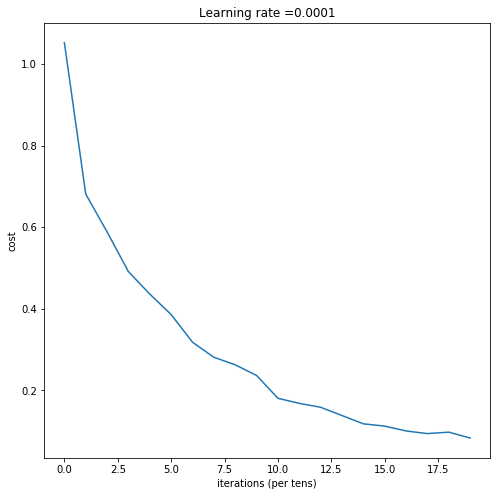



Accuracy on training set is 0.9856459332995438

Accuracy on test set is 0.9599999904632568


In [34]:
evaluate_this_model(model, 20)

## Transfer Learning on a model from Github

Apart from pretrained models provided by Keras, people often tend to implement new models and publish them on github. If developed in Keras, they usually follow the same API provided by Keras. Here, we're using [ShuffleNet](https://github.com/scheckmedia/keras-shufflenet) which is not provided by Keras.

In [35]:
from shufflenet import ShuffleNet

In [36]:
frozen2 = ShuffleNet(include_top=False)

In [37]:
frozen2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 24) 648         input_2[0][0]                    
__________________________________________________________________________________________________
maxpool1 (MaxPooling2D)         (None, 56, 56, 24)   0           conv1[0][0]                      
__________________________________________________________________________________________________
stage2/block1/1x1_gconv_1 (Conv (None, 56, 56, 36)   864         maxpool1[0][0]                   
__________________________________________________________________________________________________
stage2/blo

In [38]:
trainable2 = frozen2.output
trainable2 = Dense(128, activation="relu")(trainable2)
trainable2 = Dense(32, activation="relu")(trainable2)
trainable2 = Dense(1, activation="sigmoid")(trainable2)

In [39]:
model2 = Model(inputs=frozen2.input, outputs=trainable2)
model2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 24) 648         input_2[0][0]                    
__________________________________________________________________________________________________
maxpool1 (MaxPooling2D)         (None, 56, 56, 24)   0           conv1[0][0]                      
__________________________________________________________________________________________________
stage2/block1/1x1_gconv_1 (Conv (None, 56, 56, 36)   864         maxpool1[0][0]                   
__________________________________________________________________________________________________
stage2/blo

In [40]:
for layer in model2.layers[:-3]:
    layer.trainable = False

In [41]:
for layer in model2.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x000001D7A49ADD68> False
<keras.layers.convolutional.Conv2D object at 0x000001D7A259ACF8> False
<keras.layers.pooling.MaxPooling2D object at 0x000001D7A259AA20> False
<keras.layers.convolutional.Conv2D object at 0x000001D7A259AAC8> False
<keras.layers.normalization.BatchNormalization object at 0x000001D7A257BD68> False
<keras.layers.core.Activation object at 0x000001D7A2590668> False
<keras.layers.core.Lambda object at 0x000001D7A25A48D0> False
<keras.layers.convolutional.DepthwiseConv2D object at 0x000001D7A25820B8> False
<keras.layers.normalization.BatchNormalization object at 0x000001D7A26B7A20> False
<keras.layers.convolutional.Conv2D object at 0x000001D7A26B7CF8> False
<keras.layers.normalization.BatchNormalization object at 0x000001D7A26F8D30> False
<keras.layers.pooling.AveragePooling2D object at 0x000001D7A2741AC8> False
<keras.layers.merge.Concatenate object at 0x000001D7A27D1F28> False
<keras.layers.core.Activation object at 0x0

In [42]:
learning_rate = 0.0001
opt = Adam(lr=learning_rate)
model2.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

Epoch 1/10
209/209 [==============================] - 10s 48ms/step - loss: 1.0151 - acc: 0.5789
Epoch 2/10
209/209 [==============================] - 6s 28ms/step - loss: 0.7175 - acc: 0.5359
Epoch 3/10
209/209 [==============================] - 6s 28ms/step - loss: 0.6501 - acc: 0.6364
Epoch 4/10
209/209 [==============================] - 8s 38ms/step - loss: 0.5691 - acc: 0.7033
Epoch 5/10
209/209 [==============================] - 9s 43ms/step - loss: 0.6303 - acc: 0.6124
Epoch 6/10
209/209 [==============================] - 6s 27ms/step - loss: 0.5482 - acc: 0.6938
Epoch 7/10
209/209 [==============================] - 9s 43ms/step - loss: 0.5570 - acc: 0.6746
Epoch 8/10
209/209 [==============================] - 9s 42ms/step - loss: 0.5921 - acc: 0.6699
Epoch 9/10
209/209 [==============================] - 6s 28ms/step - loss: 0.6267 - acc: 0.6746
Epoch 10/10
50/50 [==============================] - 2s 40ms/step


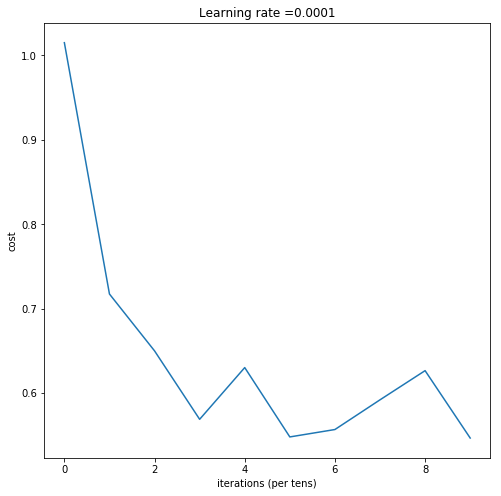



Accuracy on training set is 0.6937799063025479

Accuracy on test set is 0.34


In [43]:
evaluate_this_model(model2, 10)